In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d thoughtvector/customer-support-on-twitter

 98% 165M/169M [00:07<00:00, 27.0MB/s]
100% 169M/169M [00:07<00:00, 23.4MB/s]


In [3]:
!unzip /content/customer-support-on-twitter.zip

Archive:  /content/customer-support-on-twitter.zip
  inflating: sample.csv              
  inflating: twcs/twcs.csv           


In [2]:
import numpy as np
import codecs
import tensorflow as tf
import pandas as pd
import ast
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

In [6]:
tweets_df = pd.read_csv('/content/twcs/twcs.csv', encoding='utf-8')

In [7]:
tweets_df.head(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [18]:
tweets_df.text[:1]

0    @115712 I understand. I would like to assist y...
Name: text, dtype: object

In [8]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tweet_id                 int64  
 1   author_id                object 
 2   inbound                  bool   
 3   created_at               object 
 4   text                     object 
 5   response_tweet_id        object 
 6   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 131.4+ MB


In [9]:
tweets_df.isnull().sum()


tweet_id                         0
author_id                        0
inbound                          0
created_at                       0
text                             0
response_tweet_id          1040629
in_response_to_tweet_id     794335
dtype: int64

In [10]:
tweets_df.in_response_to_tweet_id

0                3.0
1                1.0
2                4.0
3                5.0
4                6.0
             ...    
2811769    2987948.0
2811770          NaN
2811771    2812239.0
2811772    2987950.0
2811773          NaN
Name: in_response_to_tweet_id, Length: 2811774, dtype: float64

In [14]:
tweets_df.inbound

0          False
1           True
2           True
3          False
4           True
           ...  
2811769    False
2811770     True
2811771     True
2811772    False
2811773     True
Name: inbound, Length: 2811774, dtype: bool

#Creating Data with conversation

Create another dataset containing a client's initial request and the company's response.

In [19]:
first_inbound = tweets_df[pd.isnull(tweets_df.in_response_to_tweet_id) & tweets_df.inbound]


In [20]:
first_inbound

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
12,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,NaN
14,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,NaN
23,29,115716,True,Tue Oct 31 22:01:35 +0000 2017,actually that's a broken link you sent me and ...,28,NaN
25,31,115717,True,Tue Oct 31 22:06:54 +0000 2017,"Yo @Ask_Spectrum, your customer service reps a...",30,NaN
...,...,...,...,...,...,...,...
2811763,2987942,823867,True,Wed Nov 22 07:30:39 +0000 2017,Hai @AirAsiaSupport #asking how many days need...,2987941,NaN
2811765,2987944,823868,True,Wed Nov 22 07:43:36 +0000 2017,@AirAsiaSupport \n\nI am unable to do web chec...,2987943,NaN
2811768,2987946,524544,True,Wed Nov 22 08:25:48 +0000 2017,@VirginTrains Hope you are well? Does the 9.30...,2987945,NaN
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty s...,2987947,NaN


In [21]:
inbOutb = pd.merge(first_inbound, tweets_df, left_on='tweet_id', right_on='in_response_to_tweet_id').sample(frac=1)
inbOutb = inbOutb[inbOutb.inbound_y ^ True]

In [12]:
inbOutb.shape

(794299, 14)

In [13]:
inbOutb.head()

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
8603,34366,123440,True,Sun Sep 24 21:38:13 +0000 2017,@ATVIAssist Kids can't play Skylanders Imagina...,34365,NaN,34365,ATVIAssist,False,Sun Sep 24 21:48:31 +0000 2017,@123440 Hi there! I apologize for any frustrat...,34364,34366.0
440721,1593223,489665,True,Sun Nov 05 01:10:05 +0000 2017,@SW_Help currently on a delayed train to Wokin...,"1593221,1593224",NaN,1593221,SW_Help,False,Sun Nov 05 01:17:30 +0000 2017,"@489665 of hours they can work. If we need to,...",1593222,1593223.0
422761,1531801,205484,True,Tue Oct 17 01:41:10 +0000 2017,you’re aware if 📱 battery issues and all your ...,1531800,NaN,1531800,TMobileHelp,False,Tue Oct 17 01:42:04 +0000 2017,@205484 @115913 Hello. We've got your DM and w...,NaN,1531801.0
495687,1779554,534681,True,Tue Oct 10 19:35:44 +0000 2017,@115777 i find it odd that you sell @127289 ph...,1779553,NaN,1779553,AdobeCare,False,Wed Oct 11 19:00:59 +0000 2017,"@534681 Hi there, sorry for the trouble, could...",1779549,1779554.0
406637,1475349,220845,True,Thu Nov 02 22:06:18 +0000 2017,@AmazonHelp I got a delivery notification with...,1475348,NaN,1475348,AmazonHelp,False,Thu Nov 02 22:09:27 +0000 2017,"@220845 Hello, Michael. I'm so sorry! Please p...",NaN,1475349.0


In [31]:
# Selecting only important colmns
data = inbOutb[['author_id_x', 'created_at_x', 'text_x', 'author_id_y', 'created_at_y', 'text_y']]

In [32]:

data.head()

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y
439174,488403,Sat Nov 04 22:45:35 +0000 2017,@AlaskaAir Big Thanks to Customer Service Agen...,AlaskaAir,Sat Nov 04 22:49:38 +0000 2017,@488403 YAY! Happy she could assist you today!...
406268,244086,Thu Nov 02 21:17:51 +0000 2017,@AmazonHelp 9th! I ordered via Prime because I...,AmazonHelp,Thu Nov 02 21:34:12 +0000 2017,@244086 I'm sorry for the delay with your parc...
543383,426066,Fri Oct 27 07:17:22 +0000 2017,@TMobileHelp why is only the iPhones 8 and 7 s...,TMobileHelp,Fri Oct 27 07:29:38 +0000 2017,"@426066 I apologise for the inconvenience, ple..."
84804,193237,Sat Oct 07 14:47:23 +0000 2017,@115850 I want my order to be delivered today ...,AmazonHelp,Sat Oct 07 15:00:41 +0000 2017,@193237 Sorry for the hassle. Please report th...
257194,190246,Fri Oct 13 23:59:38 +0000 2017,@115783: my host is a rockstar. Please applaud...,AirbnbHelp,Sat Oct 14 00:42:21 +0000 2017,@190246 👏 👏 👏


In [33]:
data1 = data[['text_x', 'text_y']]
data1.head()

,text_x,text_y
439174,@AlaskaAir Big Thanks to Customer Service Agen...,@488403 YAY! Happy she could assist you today!...
406268,@AmazonHelp 9th! I ordered via Prime because I...,@244086 I'm sorry for the delay with your parc...
543383,@TMobileHelp why is only the iPhones 8 and 7 s...,"@426066 I apologise for the inconvenience, ple..."
84804,@115850 I want my order to be delivered today ...,@193237 Sorry for the hassle. Please report th...
257194,@115783: my host is a rockstar. Please applaud...,@190246 👏 👏 👏


In [34]:
data1.isnull().any()

text_x    False
text_y    False
dtype: bool

In [35]:
total_strings = data1['text_x'].values.tolist() + data['text_y'].values.tolist()
all_strings = " ".join(total_strings)
pattern = re.compile(r"[\w]*'[\w]*")
matchings = re.findall(pattern, all_strings)

In [36]:
set(matchings)

{"'lewishowe",
 "macht's",
 "server's",
 "Balance'",
 "cant'",
 "n'aiment",
 "'8am",
 "'notify",
 "expired'",
 "option'",
 "d'y",
 "s'arrête",
 "screenshot's",
 "Pranom's",
 "192637's",
 "dip's",
 "misic'",
 "reppin'",
 "l'opération",
 "g'night",
 "d'applis",
 "Honiton'",
 "DomainServices'",
 "'Timberrrrrrr",
 "if's",
 "Dracula's",
 "'someone",
 "'cut",
 "'undo",
 "veg'",
 "agents'",
 "Voter's",
 "chat'",
 "tablet'",
 "Marley's",
 "'F",
 "other's",
 "l'assistenza",
 "'weekend",
 "d'envoi",
 "God'",
 "'Local",
 "dumbass'sI",
 "Roland's",
 "we'ev",
 "daughters'",
 "WVH's",
 "'checker",
 "that'aaj",
 "indie's",
 "Files'",
 "trippin'",
 "'discount",
 "J'achadore",
 "quest's",
 "m'annonce",
 "APSD's",
 "'csfr",
 "'tache",
 "proof'",
 "'European",
 "'Redirect",
 "centre'",
 "estimated'",
 "Cmon'",
 "kickin'",
 "win's",
 "MQD'S",
 "126402's",
 "10630'",
 "'password",
 "'wonky",
 "'claim",
 "500'd",
 "'darth",
 "blocked'",
 "instructions'",
 "'few",
 "Taunton's",
 "I'l",
 "'Friend",
 "when'll"

#Preprocessing

In [44]:
import numpy as np
import pandas as pd
import re, string
import nltk
import spacy
import pickle
from tqdm import tqdm
from bs4 import BeautifulSoup
from prettytable import PrettyTable  # To print in a table
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import re
from prettytable import PrettyTable
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [37]:
data1= data1.rename(columns={'text_x':'question', 'text_y':'answer'})

In [40]:
data1.head(5)

,question,answer
439174,@AlaskaAir Big Thanks to Customer Service Agen...,@488403 YAY! Happy she could assist you today!...
406268,@AmazonHelp 9th! I ordered via Prime because I...,@244086 I'm sorry for the delay with your parc...
543383,@TMobileHelp why is only the iPhones 8 and 7 s...,"@426066 I apologise for the inconvenience, ple..."
84804,@115850 I want my order to be delivered today ...,@193237 Sorry for the hassle. Please report th...
257194,@115783: my host is a rockstar. Please applaud...,@190246 👏 👏 👏


In [52]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase



def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', string)


EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}


def remove_emoticons(text):
    " Remove emoticons from text"
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

def clean_text(text):
    """
    This function clean the given data and preprocess it.
    """
    # Lower casting
    text = text.lower()

    # Remove all the mentions (words starting with '@')
    text = re.sub(r"@\S+", '', text)

    # Remove URL
    text = re.sub(r"http\S+", "", text)

    # Remove html tags
    #text = BeautifulSoup(text, 'lxml').get_text()

    # Decontracted
    text = decontractions(text)

    # Remove emoji
    text = remove_emoji(text)

    # Remove emoticons
    text = remove_emoticons(text)

    # Remove words with digit
    text = re.sub("\S*\d\S*", "", text).strip()

    # Remove any special charecters and punctuations
    text = re.sub("[^A-Za-z\n]", " ", text)

    # Remove more than 1 space
    text = " ".join(text.split())

    return text

In [53]:
# To see the progress bar in pandas apply
tqdm.pandas()

In [54]:
# Preprocessing questions
data1['clean_question'] = data1['question'].progress_apply(clean_text)
data1['clean_answer'] = data1['answer'].progress_apply(clean_text)

100%|██████████| 794299/794299 [02:32<00:00, 5212.09it/s]


In [55]:
data1.head(5)

,question,answer,clean_question,clean_answer
439174,@AlaskaAir Big Thanks to Customer Service Agen...,@488403 YAY! Happy she could assist you today!...,big thanks to customer service agent jaimee at...,yay happy she could assist you today tara
406268,@AmazonHelp 9th! I ordered via Prime because I...,@244086 I'm sorry for the delay with your parc...,i ordered via prime because i needed it tomorr...,i am sorry for the delay with your parcel plea...
543383,@TMobileHelp why is only the iPhones 8 and 7 s...,"@426066 I apologise for the inconvenience, ple...",why is only the iphones and showing up,i apologise for the inconvenience please may y...
84804,@115850 I want my order to be delivered today ...,@193237 Sorry for the hassle. Please report th...,i want my order to be delivered today else can...,sorry for the hassle please report this to our...
257194,@115783: my host is a rockstar. Please applaud...,@190246 👏 👏 👏,my host is a rockstar please applaud her,


In [57]:
data1 = data1[['clean_question', 'clean_answer']]
data1.head(2)

,clean_question,clean_answer
439174,big thanks to customer service agent jaimee at...,yay happy she could assist you today tara
406268,i ordered via prime because i needed it tomorr...,i am sorry for the delay with your parcel plea...


In [59]:
data1= data1.rename(columns={'clean_question':'question', 'clean_answer':'answer'})
data1.head(5)

,question,answer
439174,big thanks to customer service agent jaimee at...,yay happy she could assist you today tara
406268,i ordered via prime because i needed it tomorr...,i am sorry for the delay with your parcel plea...
543383,why is only the iphones and showing up,i apologise for the inconvenience please may y...
84804,i want my order to be delivered today else can...,sorry for the hassle please report this to our...
257194,my host is a rockstar please applaud her,


In [61]:
q_lengths = data1['question'].str.split().apply(len)
a_lengths = data1['answer'].str.split().apply(len)

In [63]:
from tqdm import tqdm
all_ques = " ".join(data1['question'].values)
all_ans = " ".join(data1['answer'].values)
word_cnt_a = {}
for i in tqdm(all_ans.split()): word_cnt_a[i] = word_cnt_a.get(i, 0) + 1
word_cnt_q = {}
for i in tqdm(all_ques.split()): word_cnt_q[i] = word_cnt_q.get(i, 0) + 1

100%|██████████| 15007546/15007546 [00:11<00:00, 1344478.71it/s]


In [64]:
word_ordered_a = sorted(word_cnt_a, key=lambda x: word_cnt_a[x], reverse=True)
top_20_a = word_ordered_a[:20]
cnts_20_a = [word_cnt_a[i] for i in top_20_a]

word_ordered_q = sorted(word_cnt_q, key=lambda x: word_cnt_q[x], reverse=True)
top_20_q = word_ordered_q[:20]
cnts_20_q = [word_cnt_q[i] for i in top_20_q]

In [65]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
def plot(top_words, counts):
    fig, ax = plt.subplots()

    # Save the chart so we can loop through the bars below.
    bars = ax.bar(
        x=np.arange(len(top_words)),
        height=counts,
        tick_label=top_words
    )

    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)

    # Add text annotations to the top of the bars.
    bar_color = bars[0].get_facecolor()
    for bar in bars:
      ax.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + 0.3,
          round(bar.get_height(), 1),
          horizontalalignment='center',
          color=bar_color,
          weight='bold'
      )

    # Add labels and a title. Note the use of `labelpad` and `pad` to add some
    # extra space between the text and the tick labels.
    ax.set_xlabel('Word', labelpad=15, color='#333333')
    ax.set_ylabel('Count', labelpad=15, color='#333333')
    ax.set_title("Most usual words in reply/answers", pad=15, color='#333333',
                 weight='bold')

    fig.tight_layout()

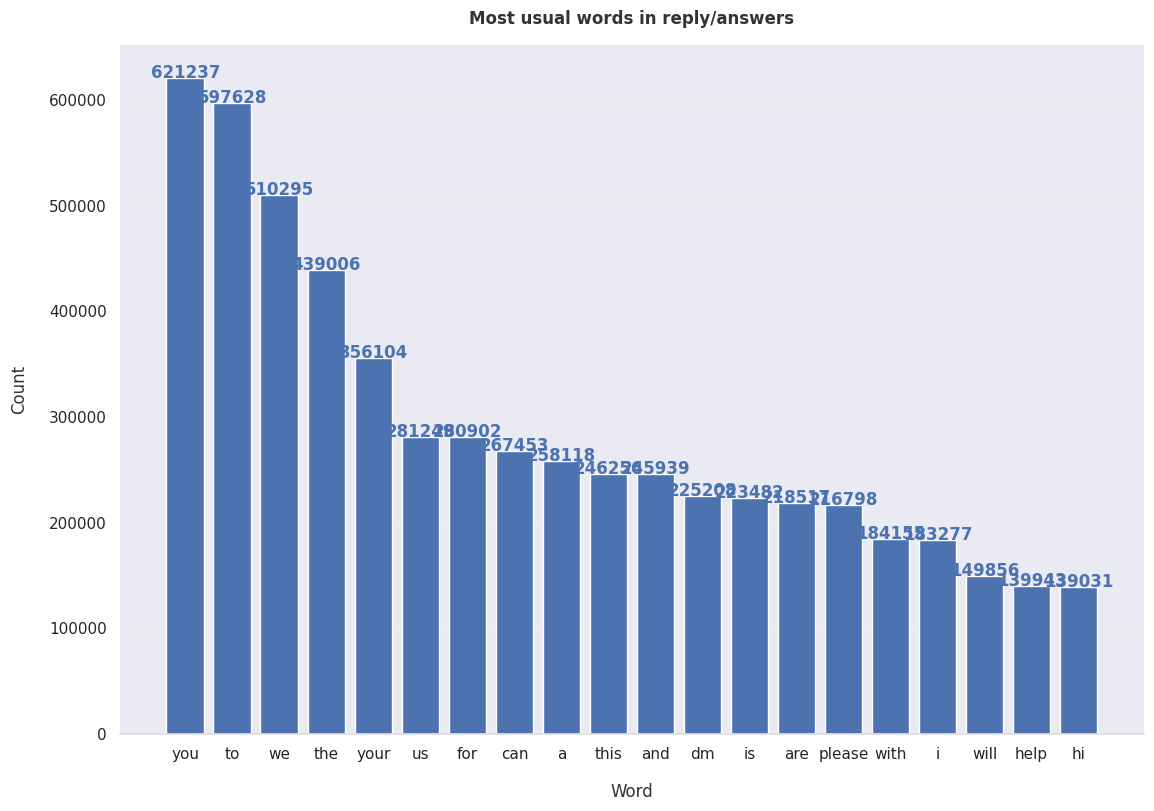

In [66]:
plot(top_20_a, cnts_20_a)

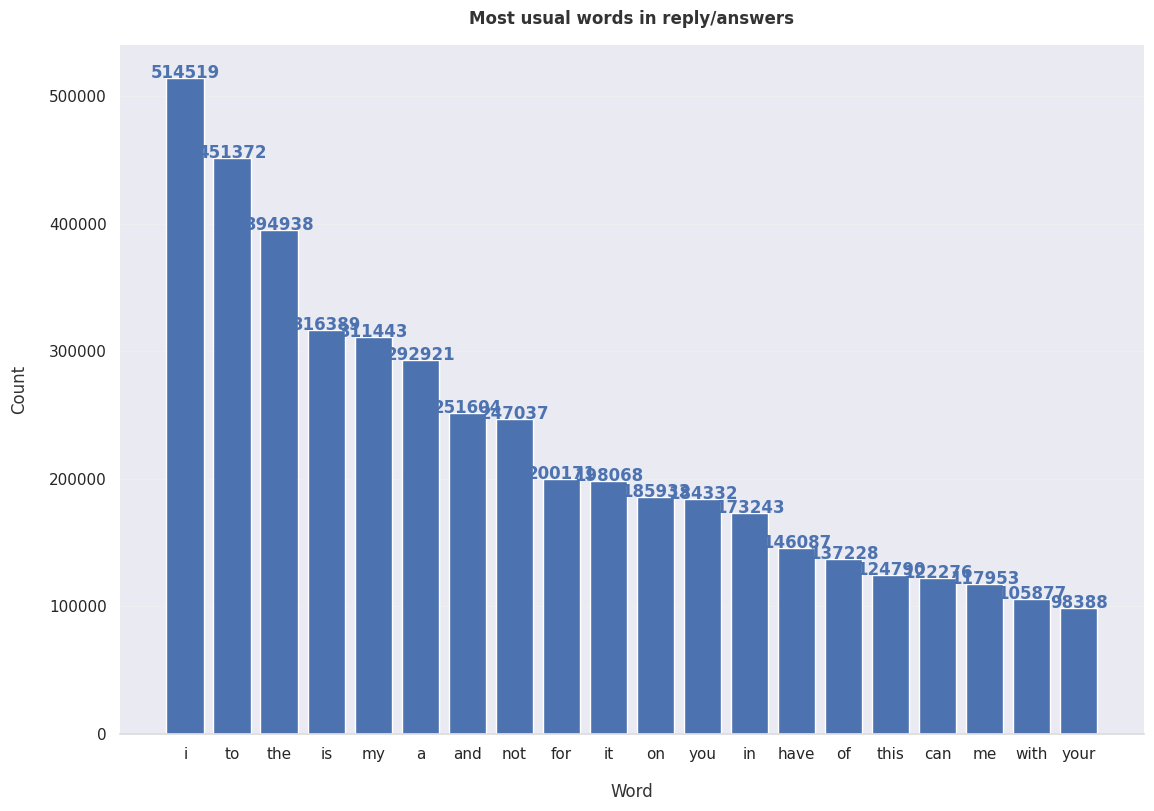

In [67]:
plot(top_20_q, cnts_20_q)

In [68]:
word_ordered_a = sorted(word_cnt_a, key=lambda x: word_cnt_a[x], reverse=True)
top_20_a = []
for i in word_ordered_a:
    if len(top_20_a) == 20: break
    if len(i) >= 5:
        top_20_a.append(i)
cnts_20_a = [word_cnt_a[i] for i in top_20_a]

word_ordered_q = sorted(word_cnt_q, key=lambda x: word_cnt_q[x], reverse=True)
top_20_q = []
for i in word_ordered_q:
    if len(top_20_q) == 20: break
    if len(i) >= 5:
        top_20_q.append(i)
cnts_20_q = [word_cnt_q[i] for i in top_20_q]

Most used words having length > 5, questions


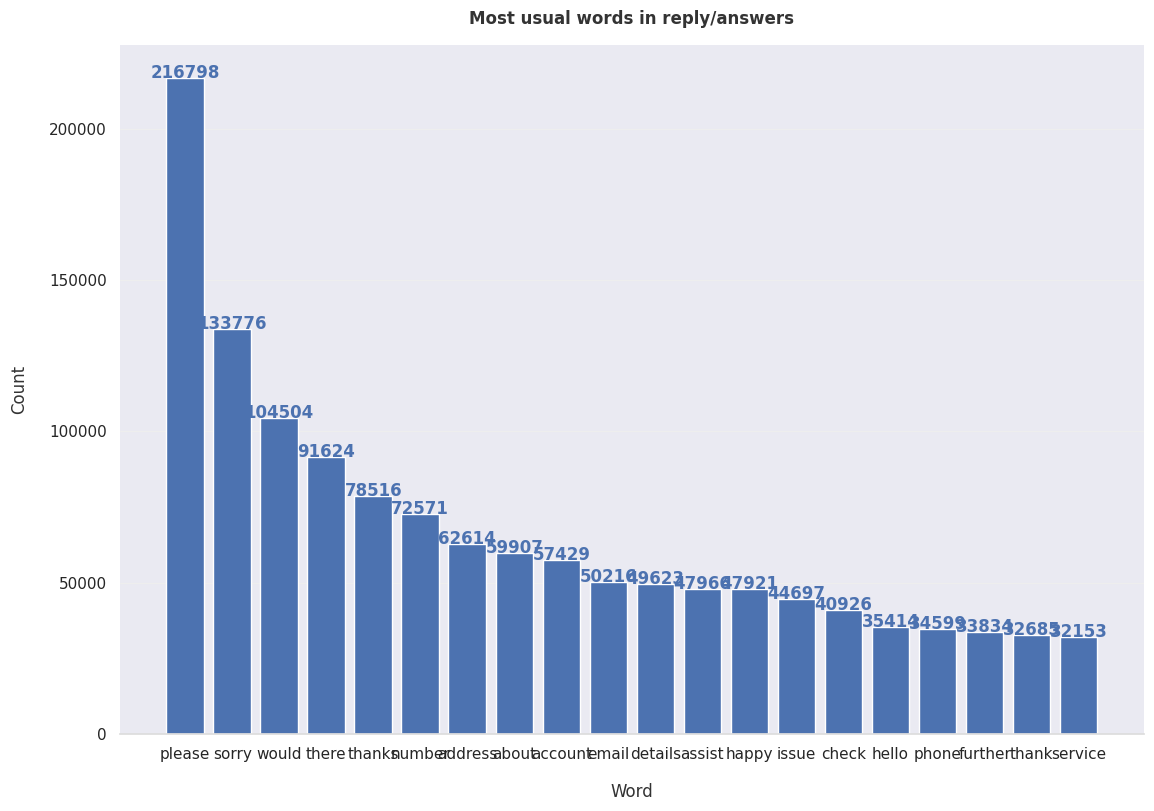

In [69]:
plot(top_20_a, cnts_20_a)

Most used words having length > 5, questions

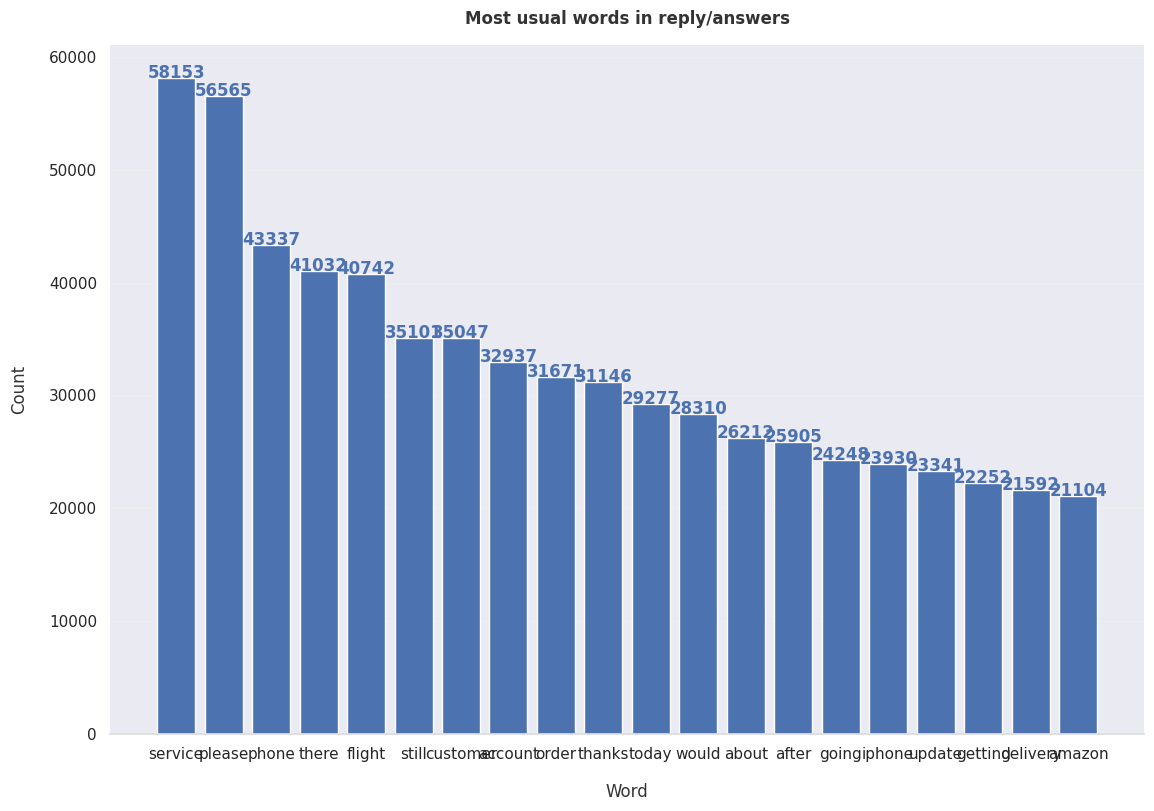

In [70]:
plot(top_20_q, cnts_20_q)


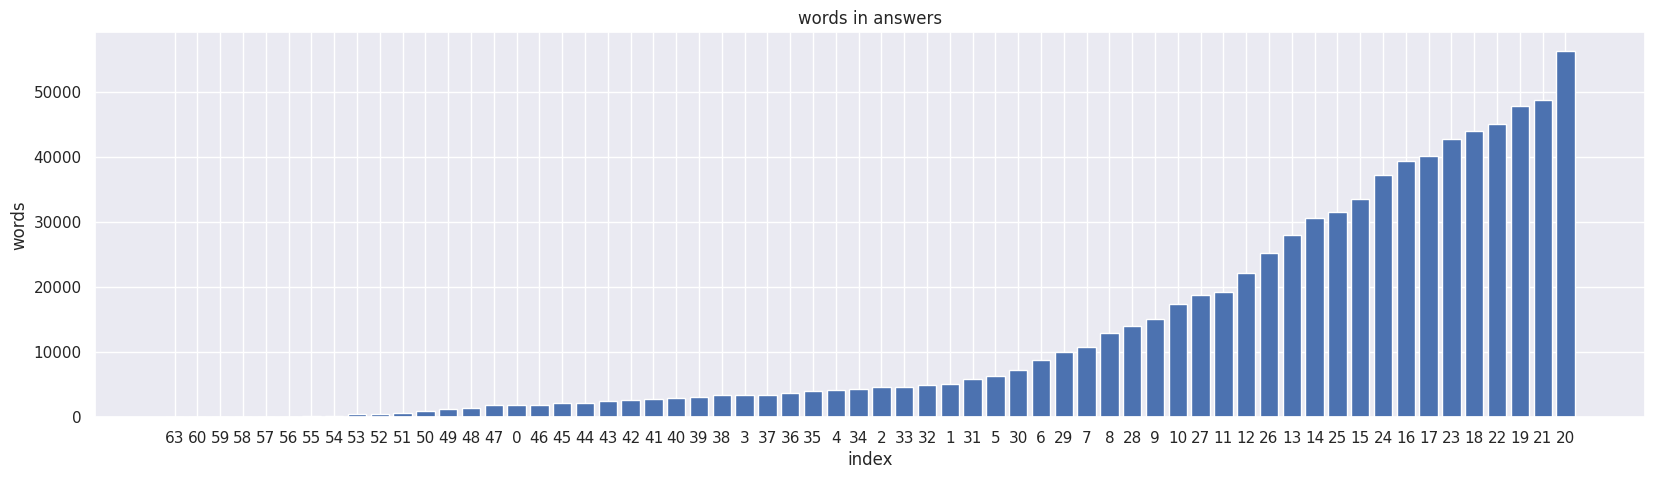

In [72]:
answer_count = data1['answer'].str.split().apply(len).value_counts()
word_dict = dict(answer_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('words')
plt.xlabel('index')
plt.title('words in answers')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

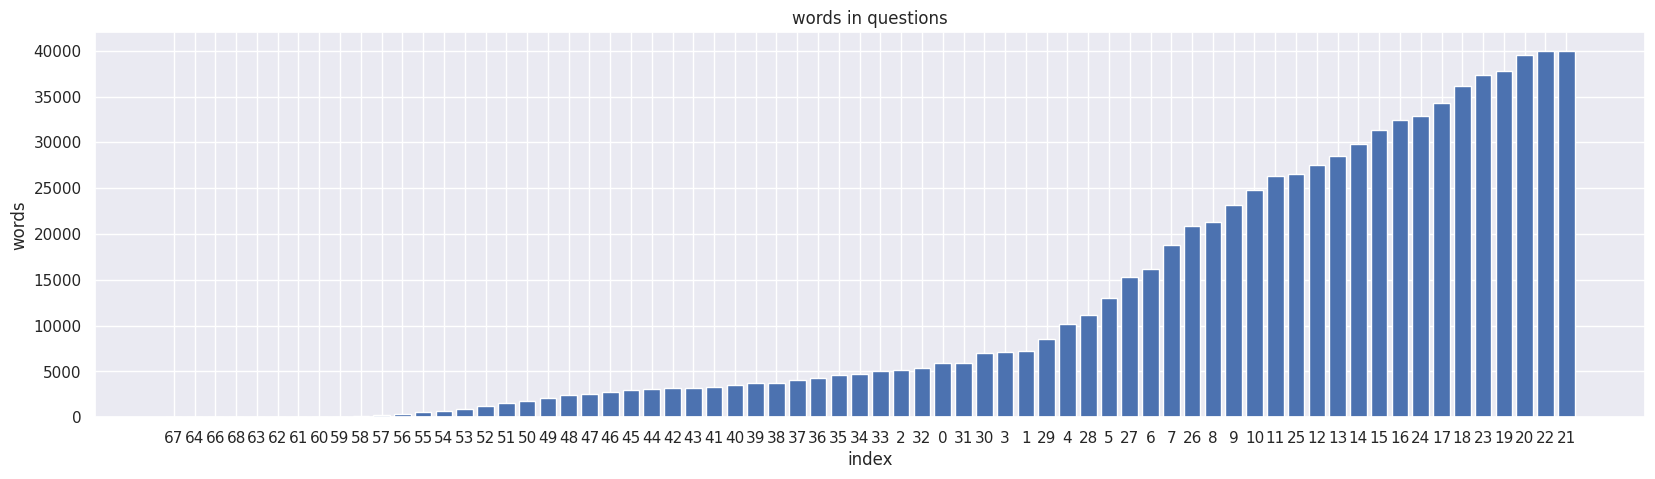

In [73]:
answer_count = data1['question'].str.split().apply(len).value_counts()
word_dict = dict(answer_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('words')
plt.xlabel('index')
plt.title('words in questions')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [74]:
data1['answer_in'] = '<start> ' + data1['answer'].astype(str)
data1['answer_out'] = data1['answer'].astype(str) + ' <end>'
data1.head()

,question,answer,answer_in,answer_out
439174,big thanks to customer service agent jaimee at...,yay happy she could assist you today tara,<start> yay happy she could assist you today tara,yay happy she could assist you today tara <end>
406268,i ordered via prime because i needed it tomorr...,i am sorry for the delay with your parcel plea...,<start> i am sorry for the delay with your par...,i am sorry for the delay with your parcel plea...
543383,why is only the iphones and showing up,i apologise for the inconvenience please may y...,<start> i apologise for the inconvenience plea...,i apologise for the inconvenience please may y...
84804,i want my order to be delivered today else can...,sorry for the hassle please report this to our...,<start> sorry for the hassle please report thi...,sorry for the hassle please report this to our...
257194,my host is a rockstar please applaud her,,<start>,<end>


In [75]:
data_final = data1.drop(['answer'], axis=1)
data_final.head()

,question,answer_in,answer_out
439174,big thanks to customer service agent jaimee at...,<start> yay happy she could assist you today tara,yay happy she could assist you today tara <end>
406268,i ordered via prime because i needed it tomorr...,<start> i am sorry for the delay with your par...,i am sorry for the delay with your parcel plea...
543383,why is only the iphones and showing up,<start> i apologise for the inconvenience plea...,i apologise for the inconvenience please may y...
84804,i want my order to be delivered today else can...,<start> sorry for the hassle please report thi...,sorry for the hassle please report this to our...
257194,my host is a rockstar please applaud her,<start>,<end>


#Train test split of the dataset

In [77]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data_final, test_size=0.2)

In [78]:
train.iloc[0]['answer_in']= str(train.iloc[0]['answer_in'])+' <end>'
train.iloc[0]['answer_out']= str(train.iloc[0]['answer_out'])+' <end>'

In [ ]:
train

#Saving data

In [85]:
import joblib
joblib.dump(train, "train")
joblib.dump(validation, "validation")


['validation']